# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [3]:
data = pd.read_excel('geo_comment.xlsx')

In [4]:
data.head(5)

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [5]:
data1 = pd.read_excel('geo.xlsx')

In [6]:
data1.head(5)

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


Не будем нормировать данные, так порядок примрно одинаковый

In [7]:
data1['comment_class'].value_counts()

-1    95147
 1    13659
Name: comment_class, dtype: int64

In [8]:
data1['x'].value_counts()

37.442095    7338
37.454528    3616
37.559640    3563
37.685934    2962
37.805293    2816
             ... 
37.648717       1
37.647387       1
37.529636       1
37.652723       1
37.729718       1
Name: x, Length: 2457, dtype: int64

In [9]:
data1['y'].value_counts()

55.883792    7338
55.792331    3616
55.768831    3563
55.751193    2962
55.799532    2816
             ... 
55.603593       1
55.644496       1
55.850909       1
55.811138       1
55.820319       1
Name: y, Length: 2472, dtype: int64

Расмотрим рспределние полижительнх и отрицательных ответов в на карте.

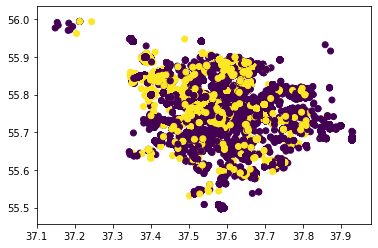

In [10]:
plt.scatter(data1['x'], data1['y'], c = data1['comment_class'])

In [11]:
X = data1[['x', 'y']]
y = data1['comment_class']
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
Unnamed: 0       108806 non-null int64
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


In [13]:
k_inertia = []
ks = range(1,11)
for i in ks:
    km = KMeans(n_clusters=i)
    clusters_kmeans = km.fit_predict(X)
    k_inertia.append(km.inertia_)

In [14]:
k_inertia

[2146.7534558639045,
 952.6381267587478,
 542.8435977458901,
 355.32003489579307,
 280.54172917944027,
 231.98917661264235,
 198.06790298894842,
 166.6004111506157,
 143.0942132101663,
 124.62081374954981]

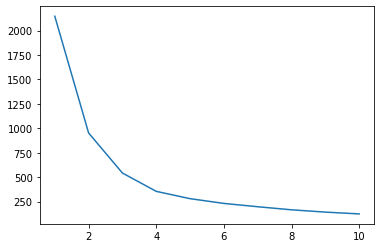

In [15]:
plt.plot(ks, k_inertia)

при 5 кластерах идет резкое змедление инерции

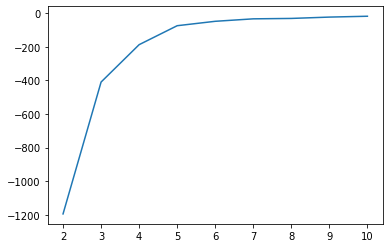

In [16]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

In [17]:
km = KMeans(n_clusters=5)
clusters_kmeans = km.fit_predict(X)
clusters_kmeans.shape

(108806,)

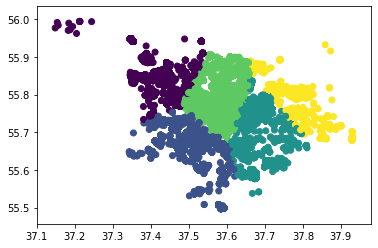

In [18]:
plt.scatter(data1['x'], data1['y'], c = clusters_kmeans)

Попробем применить dbscan для кластеризации. Минимальное количество для двух измерений выбрал 4, так как есть рекомендации в литературе (для большего количество dimension * 2). Эписилон подбирал ниже двумя способами:
1) рассчитал с помощью NearestNeighbors расстоянии каждой точки для ближайших ее 4х соседей и затем усреднил значение. это и есть эпсилон
2) рассчитал расстояния и разметил на графике. в точке максимального изменения функции находится требуемое значение
Значение эпсилон примерно от 0.0008 до 0.001
К сожалению кластеров получилось очень много (порядка 820) и выделить какую-то конкретную область достаточно сложно.

In [48]:
dbs = DBSCAN(min_samples=4, eps=0.001)
db = dbs.fit_predict(X)
db.max()

820

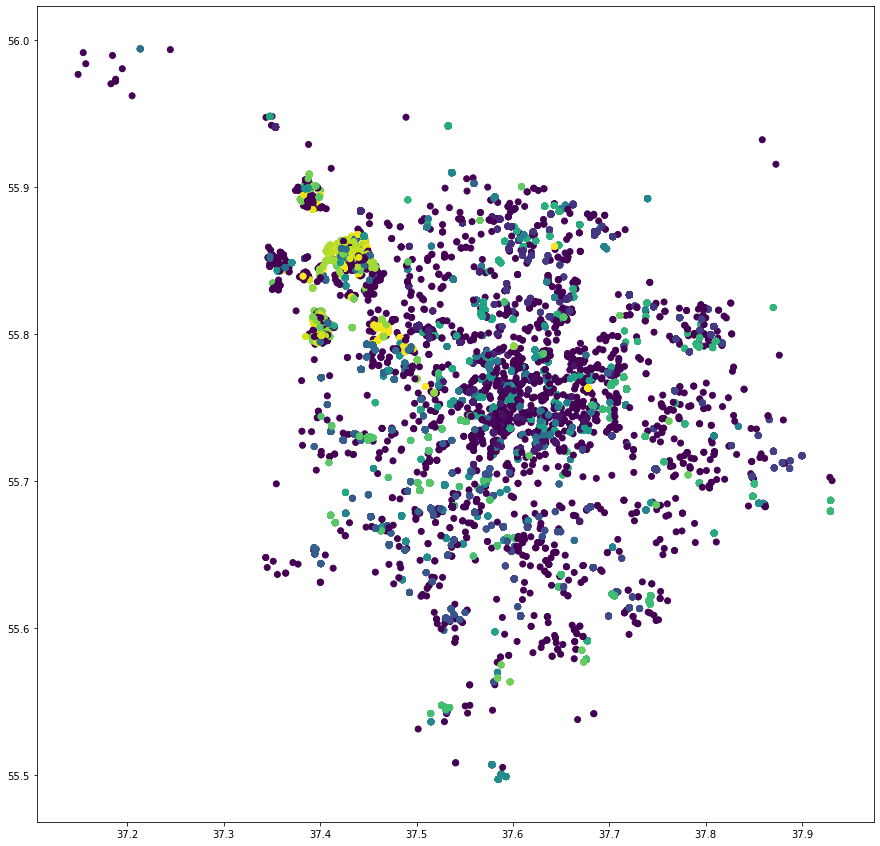

In [53]:
plt.figure(figsize=(15, 15))
plt.scatter(data1['x'], data1['y'], c = db)

Попробо увеличить эпсилон до 0.02 преследуя цель уменьшить количество кластеров. Класеров стало 12

In [50]:
dbs = DBSCAN(min_samples=4, eps=0.02)
db1 = dbs.fit_predict(X)
db1.max()

12

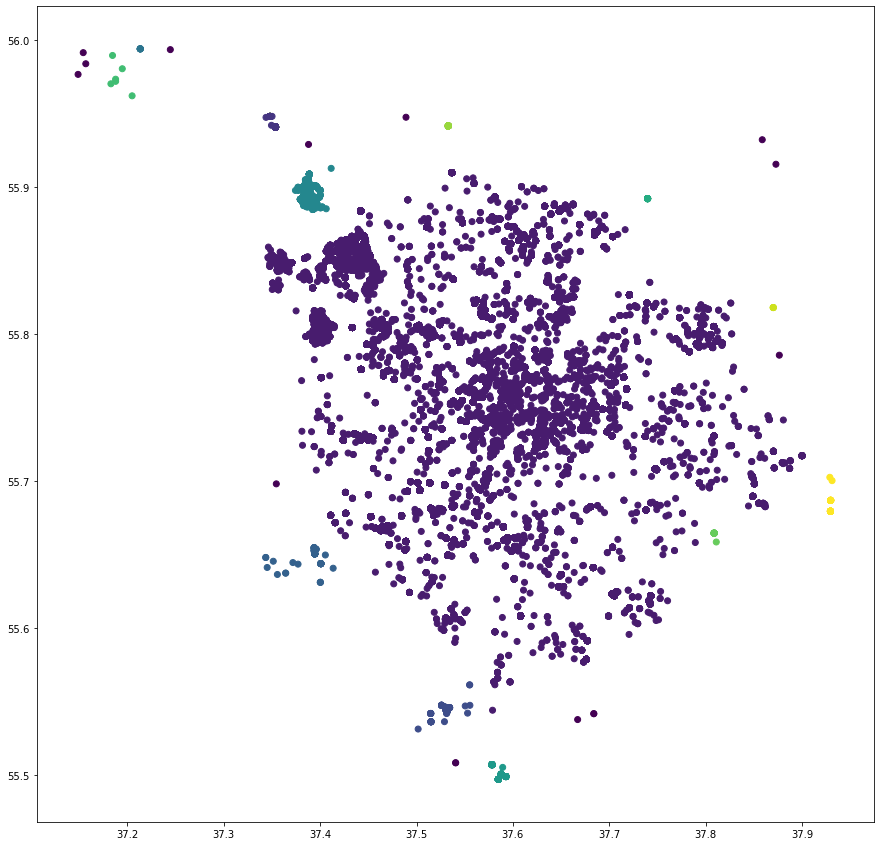

In [51]:
plt.figure(figsize=(15, 15))
plt.scatter(data1['x'], data1['y'], c = db1)

Рассчет значения эпсилон метод 2

In [22]:
from sklearn.neighbors import NearestNeighbors

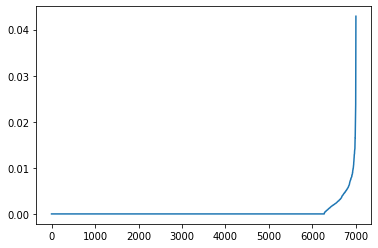

In [36]:
nbrs = NearestNeighbors(n_neighbors=4).fit(X.iloc[0:7000])
distances, indices = nbrs.kneighbors(X.iloc[0:7000])
distance = distances[:,1]
distance = np.sort(distances, axis=0)
distance = np.sort(distances, axis=0)
#distances = distance[:,1]
plt.plot(distance[:,1])

Рассчет значения эпсилон метод 1

In [24]:
distance[:, 1:4].mean()

0.0008623831623508742

In [25]:
distance[:, 2].mean()

0.0008932748219231938

In [26]:
distance[:, 3].mean()

0.001219392850009112

для понимания, что на выходе выдает функция NearestNeighbors

In [27]:
sample = np.array([[1,1], [1,2], [1,3], [1,4]])
n = NearestNeighbors(n_neighbors=3)
c = n.fit(sample)
distances, indices = c.kneighbors(sample)

In [28]:
distances

array([[0., 1., 2.],
       [0., 1., 1.],
       [0., 1., 1.],
       [0., 1., 2.]])

In [29]:
indices

array([[0, 1, 2],
       [1, 0, 2],
       [2, 1, 3],
       [3, 2, 1]], dtype=int64)

In [30]:
distances[:, 1]

array([1., 1., 1., 1.])